# COVID-19 growth analysis
Fork from Thomas Wiecki notebook
(c) 2020, [Thomas Wiecki](https://twitter.com/twiecki)

This notebook gets up-to-date data from the ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19) and recreates the (pay-walled) plot in the [Financial Times]( https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441).

In [146]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import requests
import io
from scipy import stats

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

## Load data

In [168]:
download_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv(download_dir + 'time_series_19-covid-Confirmed.csv')
df_d = pd.read_csv(download_dir + 'time_series_19-covid-Deaths.csv')
df_r = pd.read_csv(download_dir + 'time_series_19-covid-Recovered.csv')

#Data cleaning
df = df.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df_d = df_d.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df_r = df_r.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df.columns.name = ''
df_d.columns.name = ''
df_r.columns.name = ''

last_date = df.index[-1]
df.index = np.arange(df.shape[0])[::-1]*-1
df_d.index = np.arange(df_d.shape[0])[::-1]*-1
df_r.index = np.arange(df_r.shape[0])[::-1]*-1

df_c = df_d + df_r #closed cases
df_o = df - df_c #open cases

ind_cases = df.iloc[-1] > 1000
country_list = list(df_c.columns[ind_cases])
country_list.append('Netherlands')
colors = sns.color_palette(n_colors=len(country_list))

In [169]:
country='Greece'
print('Latest Cases in {}: {} (deaths: {}) (Recovered: {})'.format(country,df.loc[0,'Greece'],df_d.loc[0,'Greece'],df_r.loc[0,'Greece']))

Latest Cases in Greece: 530 (deaths: 13) (Recovered: 19)


In [170]:
# Some old data are wrong, for greece, here we put the correct ones
df.at[(pd.datetime(2020,3,17,18)-pd.datetime.today()).days,'Greece']=352
df.at[(pd.datetime(2020,3,20,18)-pd.datetime.today()).days,'Greece']=464
df_d.at[(pd.datetime(2020,3,22,18)-pd.datetime.today()).days,'Greece']=10

In [171]:
df_d['Greece'].tail()

-4     5
-3     5
-2     6
-1    10
 0    13
Name: Greece, dtype: int64

In [172]:

# mortality_total = df_d.iloc[-1].sum() / df.iloc[-1].sum() * 100
# mortality_closed = df_d.iloc[-1].sum() / (df_c.iloc[-1].sum()) * 100
mortality_total = df_d['China'].loc[0] / df['China'].loc[0] * 100
mortality_closed = df_d['China'].loc[0] / (df_c['China'].loc[0]) * 100
print('mortality rate total = {}%'.format(round(mortality_total, 3)))
print('mortality rate closed = {}%'.format(round(mortality_closed, 3)))
mortality = (mortality_total + mortality_closed) / 2
print(mortality)

mortality rate total = 4.008%
mortality rate closed = 4.339%
4.173493249572326


In [173]:
# calculate from the deaths (for any country) and mortality rate the true infected number
mort=mortality_total
df_p20=df_d*100/mort
# The infected to death period is 20 days, so the above estimation is 20 days before 
df_p20.index=df_p20.index-20

In [174]:
# When a country passed a specific number of cases (here 70) because the rate before this number is very noisy
# Calculate when this happened for every country
c_70={}
for col in df.columns:
    c_70.update({col:np.abs(df[col]-70).sort_values().index[0]})

In [175]:
days=-20
# For every day after the -20 from today estimate the eral cases
for n in np.arange(days+1,1,1):
    tmp={}
    for col in df.columns:
        if n<c_70[col]: #if the anancounced cases are below the noisy threshold just keep the observed statistc growth of 33%
            tmp.update({col:[1.33*df_p20.loc[n-1,col]]})
        else: #else calculate the rate from the anancouned cases and update the real cases from it
            rate=df.loc[n,col]/df.loc[n-1,col]
            tmp.update({col:[rate*df_p20.loc[n-1,col]]})
    df_p20=df_p20.append(pd.DataFrame(data=tmp,index=[n]))

/home/astromix/anaconda3/envs/env37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/home/astromix/anaconda3/envs/env37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [176]:
df_p20['Greece'].tail()

-4    12656.855959
-3    15175.145129
-2    13670.712638
-1    16189.001808
 0    17333.678704
Name: Greece, dtype: float64

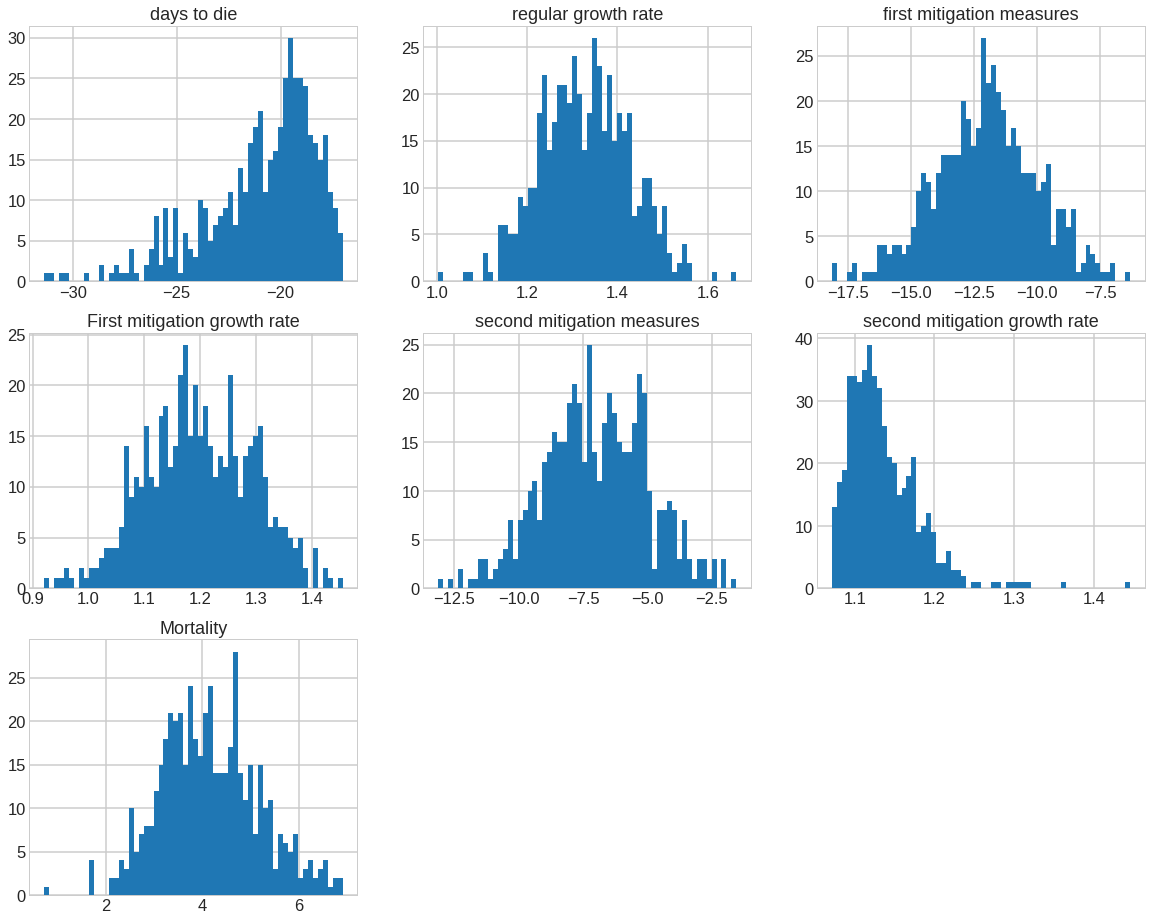

In [177]:
# Monte Carlo Simulation
N=500 #number of trajectories of the cases
columns=['Greece'] #for what countries, reduce the calculation

fig = plt.figure(figsize=(20,16))
#How many days does it take for an infected to die?
# We use a gamma distribution (usefull for boundaries)
days=-stats.gamma.rvs(a=2,loc=17,scale=2,size=N)
axd0 = fig.add_subplot(3,3,1)
axd0.hist(days,bins=60);
axd0.set_title('days to die')

# Statistical general growth rate
#normal distribution
rate0=stats.norm.rvs(loc=1.33,scale=0.1,size=N)
axr0 = fig.add_subplot(3,3,2)
axr0.hist(rate0,bins=60);
axr0.set_title('regular growth rate')

# When the first mitigation measures had been taken (schools closed)
days1=stats.norm.rvs(loc=(pd.datetime(2020,3,11,18)-pd.datetime.today()).days,scale=2,size=N)
axd1 = fig.add_subplot(3,3,3)
axd1.hist(days1,bins=60);
axd1.set_title('first mitigation measures')

# First mitigation growth rate
rate1=stats.norm.rvs(loc=1.2,scale=0.1,size=N)
axr1 = fig.add_subplot(3,3,4)
axr1.hist(rate1,bins=60);
axr1.set_title('First mitigation growth rate')

# When the sceond mitigation measures had been taken 
days2=stats.norm.rvs(loc=(pd.datetime(2020,3,16,18)-pd.datetime.today()).days,scale=2,size=N)
axd2 = fig.add_subplot(3,3,5)
axd2.hist(days2,bins=60);
axd2.set_title('second mitigation measures')

# Second mitigation growth rate
# Gamma distribution it seems that the official growth rate is 7~9%, so we keep the 7% as the lowest possible growth rate 
rate2=stats.gamma.rvs(a=2,loc=1.07,scale=0.035,size=N)
axr2 = fig.add_subplot(3,3,6)
axr2.hist(rate2,bins=60);
axr2.set_title('second mitigation growth rate')

#mortality rate, normal around 4.2 (probably in reality it is lower which makes the real cases far bigger, proabbaly we musta take population statistics)
mort=stats.norm.rvs(loc=4.2,scale=1,size=N)
axm = fig.add_subplot(3,3,7)
axm.hist(mort,bins=60);
axm.set_title('Mortality')

i=0
#take a random set of parameters from above
for m,d,r0,r1,d1,r2,d2 in zip(mort,days.astype(int),rate0,rate1,days1,rate2,days2):
    predf=df_d[columns]*100/m #just as before, how many real cases
    predf.index=predf.index+d # move the cases d days before now
    for n in np.arange(d+1,1,1): #for every day
        tmp={}
        for col in columns:
            if n<d1:
                tmp.update({col:[r0*predf[col].loc[n-1]]})
            elif n<d2:
                tmp.update({col:[r1*predf[col].loc[n-1]]})
            else:
                tmp.update({col:[r2*predf[col].loc[n-1]]})
        predf=predf.append(pd.DataFrame(data=tmp,index=[n]))
    if i>0:
        df_concat = pd.concat([df1, predf])
        df1=df_concat.copy()
    else:
        df1=predf.copy()
    i=i+1

In [178]:
# Calculate the median and -1 \sigma +1 \sigma cases for every day
minvv=np.array([])
medvv=np.array([])
maxvv=np.array([])
nn=np.arange(-30,1,1)
for n in nn:
    minv,medv,maxv=np.quantile(df_concat.loc[n],q=[0.5-0.341,0.5,0.5+0.341])
    minvv=np.append(minvv,minv)
    medvv=np.append(medvv,medv)
    maxvv=np.append(maxvv,maxv)

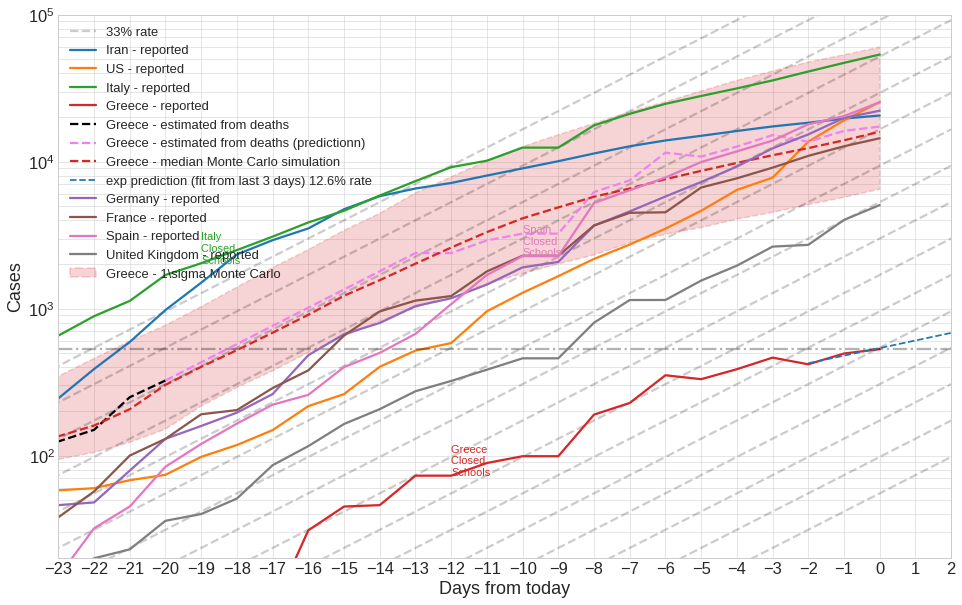

In [183]:
fig = plt.figure(figsize=(16,10))
countries=['Iran','US','Italy','Greece', 'Germany', 'France', 'Spain','United Kingdom']#, 'Poland']#, 'Iran']
colors = sns.color_palette(n_colors=len(countries))
min_cases=20
xlim=[-23,2]
#xlim=[-50,2]
ylim=[min_cases,1e5]
#ylim=[min_cases,1e7]
school_closed={'Greece':(pd.datetime(2020,3,11)-pd.datetime.today()).days,
               'Italy':(pd.datetime(2020,3,4)-pd.datetime.today()).days,
               'Spain':(pd.datetime(2020,3,13)-pd.datetime.today()).days}
karadin={'Italy':(pd.datetime(2020,3,9)-pd.datetime.today()).days,
        'Spain':(pd.datetime(2020,3,15)-pd.datetime.today()).days}

#33 % lines
x = np.linspace(-36,xlim[1])
plt.plot(x,10 * (1.33) ** (x+36), ls='--', color='k',alpha=0.2,label='33% rate')   
for x0 in np.arange(-34,-4,2):#[-30,-25,-20,-15,-10]:
    x = np.linspace(x0,xlim[1])
    plt.plot(x,10 * (1.33) ** (x-x0), ls='--', color='k',alpha=0.2)

#Main plot    
for country,color in zip(countries,colors):
    x=np.array(df.loc[:,country].index)
    y=np.array(df.loc[:,country])
    plt.plot(x,y,color=color, label='{} - reported'.format(country))
    #plt.plot(df_p20.loc[:,country],color=color, ls='--', label='{} - estimated from deaths'.format(country))
    if country=='Greece':
        plt.axhline(y[-1],color='black',alpha=0.3,linestyle='-.')
        
        
        #Estimation from the dead (-20 days)
        plt.plot(df_p20.loc[:-20,country],color='black', ls='--', label='{} - estimated from deaths'.format(country))
        #Estimation from the dead (prediction)
        plt.plot(df_p20.loc[-20:,country],color='violet', ls='--', label='{} - estimated from deaths (predictionn)'.format(country))
        #Monte carlo median and -1/1 sigma
        plt.plot(nn,medvv,color=color, ls='--', label='{} - median Monte Carlo simulation'.format(country))
        plt.fill_between(nn,minvv,maxvv,color=color, ls='--', label='{} - 1\\sigma Monte Carlo'.format(country),alpha=0.2)
        # polynomial log fit of the last 3 days from the official cases
        pf=np.polyfit(x[-3:],np.log(y[-3:]),1)
        xx=np.linspace(x[-3],xlim[1],20)
        plt.plot(xx,np.exp(np.poly1d(pf)(xx)),linewidth=1.75,linestyle='--',label='exp prediction (fit from last 3 days) {:.1f}% rate'.format((np.exp(pf[0])-1)*100))
    
    if country in list(school_closed.keys()):
        for d in [0]:#,10,14]:
            s='{} Closed schools (+{})'.format(country,d) if d>0 else '{} \nClosed \nSchools'.format(country)
            plt.text(school_closed[country]+d,y[np.argmin(np.abs(x-school_closed[country]+d))],s,fontsize=11,color=color)
            #plt.axvline(school_closed[country]+d,alpha=1,linewidth=1.2,color=color)#,label='{} Closed schools (+{})'.format(country,d)  
plt.yscale('log')
plt.grid(True,which="both",linewidth=0.5)
plt.xticks(np.arange(xlim[0], xlim[1]+1, 1))
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Days from today')
plt.ylabel('Cases')
plt.legend(fontsize=13)

In [180]:
#ta parakatw einai alli douleia

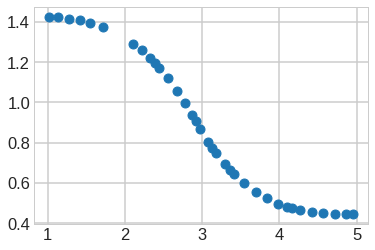

In [86]:
plt.plot(SIdata[:,0],SIdata[:,1],'o')

In [90]:
from lmfit import Model

In [98]:
def Rc(x,A,K,Q,b,x0,n):
    return A+(K-A)/(1+Q*np.exp(-b*(x-x0)))**(1/n)
def Rc(x,A,K,Q,b,n):
    return A+(K-A)/(1+Q*np.exp(-b*(x)))**(1/n)

In [99]:
rcmodel=Model(Rc)

In [100]:
x=SIdata[:,0]
y=SIdata[:,1]

In [101]:
parh={'A':{'value':1.4,'min':0,'max':2,'vary':True},
      'K':{'value':0.4,'min':0,'max':1,'vary':True},
      'Q':{'value':1,'min':0,'max':15,'vary':True},
      'b':{'value':1,'min':0.,'max':10,'vary':True},
      'x0':{'value':2,'min':0.,'max':5,'vary':True},
      'n':{'value':1,'min':0.,'max':5,'vary':True}}
rcmodel.param_hints=parh; rcmodel.make_params()
rcfit=rcmodel.fit(x=x, data=y)#,weights=s[wsp]*0.1)#,nan_policy='omit', method='nelder')

In [102]:
print(rcfit.fit_report())

[[Model]]
    Model(Rc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 35
    # variables        = 6
    chi-square         = 4.45104646
    reduced chi-square = 0.15348436
    Akaike info crit   = -60.1773092
    Bayesian info crit = -50.8452208
##  Warning: uncertainties could not be estimated:
    Q:   at boundary
    x0:  at initial value
[[Variables]]
    A:   5.7554e-05 (init = 1.4)
    K:   0.87553816 (init = 0.4)
    Q:   0.00000000 (init = 1)
    b:   0.11630252 (init = 1)
    n:   2.56836044 (init = 1)
    x0:  2.00000000 (init = 2)



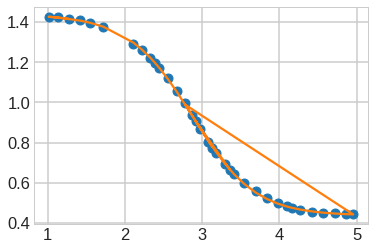

In [97]:
plt.plot(x,y,'o')
plt.plot(x,Rc(x,**rcfit.best_values))